# Notebook for Differential Gene Expression of CosMX RNA Data

# TODO
- xxx

## Instructions

- The seurat object you load should have the variables used for DGE analysis already defined
- Helper functions are defined in helper_functions.R (imported with other imports)
- See Scratch Space Blog https://nanostring-biostats.github.io/CosMx-Analysis-Scratch-Space/posts/vignette-basic-analysis-updated/03_DE.html for more information

## Imports

In [1]:
# Load Packages
library("Seurat")
library("dplyr")
library(ggplot2)
library(gridExtra)
library(patchwork)
library(data.table)
library(Matrix)
library(matrixStats)
library(harmony)
library(ggrepel)
library(pals)
library(RColorBrewer)
library(ggrastr)
library(cluster)
library(ggrepel)
library(gtools)
library(HieraType)
# library(InSituType)
library(ComplexHeatmap)
library(scales)
library(smiDE)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: Rcpp

Loading required package: grid

ComplexHeatmap version 2.22.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use 

In [2]:
# Load helper functions
source("helper_functions.R")

## Data Loading

In [3]:
# Define directories
file_path <- "./data/smiDE_TMA12.rds" # Path to seurat object
out_dir <- "./output" # Base output folder
# study_name <- "Test"
study_name <- "TMA12"
full_out_dir <- file.path(out_dir, study_name, "DGE") # Output folder for this study
dir.create(full_out_dir, showWarnings = FALSE, recursive = TRUE)

In [4]:
seu <- readRDS(file_path)

In [5]:
# Set RNA as Default Assay
ASSAY_NAME <- "RNA"
DefaultAssay(seu) <- ASSAY_NAME

# Calculate Normalized Counts
normed <- HieraType::totalcount_norm(Matrix::t(seu[[ASSAY_NAME]]$counts))
seu <- Seurat::SetAssayData(seu, layer = "data", new.data = Matrix::t(normed))

## Subset Data as necessary

In [6]:
# Testing Code
set.seed(123) # for reproducibility
if (ncol(seu) > 70000) {
    sampled_cells <- sample(colnames(seu), 70000)
    seu <- seu[, sampled_cells]
}

In [7]:
# Check metadata
colnames(seu@meta.data)
table(seu@meta.data$log.neighboring.tumor_bins_simple)

[1] "RNA_QC_Cell.Typing.InSituType.1_1_clusters"                               
  [2] "RNA_QC_Cell.Typing.InSituType.1_1_posterior_probability"                  
  [3] "fov"                                                                      
  [4] "Area"                                                                     
  [5] "AspectRatio"                                                              
  [6] "x_FOV_px"                                                                 
  [7] "y_FOV_px"                                                                 
  [8] "Width"                                                                    
  [9] "Height"                                                                   
 [10] "Mean.PanCK"                                                               
 [11] "Max.PanCK"                                                                
 [12] "Mean.G"                                                                   
 [13] "Max.G"                                                                    
 [14] "Mean.Membrane"                                                            
 [15] "Max.Membrane"                                                             
 [16] "Mean.CD45"                                                                
 [17] "Max.CD45"                                                                 
 [18] "Mean.DAPI"                                                                
 [19] "Max.DAPI"                                                                 
 [20] "SplitRatioToLocal"                                                        
 [21] "NucArea"                                                                  
 [22] "NucAspectRatio"                                                           
 [23] "Circularity"                                                              
 [24] "Eccentricity"                                                             
 [25] "Perimeter"                                                                
 [26] "Solidity"                                                                 
 [27] "cell_id"                                                                  
 [28] "assay_type"                                                               
 [29] "version"                                                                  
 [30] "Run_Tissue_name"                                                          
 [31] "Panel"                                                                    
 [32] "cellSegmentationSetId"                                                    
 [33] "cellSegmentationSetName"                                                  
 [34] "slide_ID_numeric"                                                         
 [35] "sdimx"                                                                    
 [36] "sdimy"                                                                    
 [37] "cell_ID"                                                                  
 [38] "unassignedTranscripts"                                                    
 [39] "median_RNA"                                                               
 [40] "RNA_quantile_0.75"                                                        
 [41] "RNA_quantile_0.8"                                                         
 [42] "RNA_quantile_0.85"                                                        
 [43] "RNA_quantile_0.9"                                                         
 [44] "RNA_quantile_0.95"                                                        
 [45] "RNA_quantile_0.99"                                                        
 [46] "nCount_RNA"                                                               
 [47] "nFeature_RNA"                                                             
 [48] "median_negprobes"                                                         
 [49] "negprobes_quantile_0.75"                                   


Close to tumor Far from tumor         Middle 
         45284          12674          11904 

## Define Parameters

In [8]:
sdimx_col <- "sdimx"
sdimy_col <- "sdimy"

celltype_col <- "broad_annotation"
cellid_col <- "cell_ID_new"
celltype_oi <- "t_cell"
de_var <- "log.neighboring.tumor_bins_simple"

# Overlap Ratio Params
radius <- 0.05
split_neighbors_by_colname <- "region" # defines one or more metadata columns used to partition cells before neighbor computation (partitions are distinct)
overlap_threshold <- 1

# smiDE params
use_random_intercept <- TRUE
random_intercept_col <- "study_id"

## Preparing Data

In [9]:
counts <- Matrix::t(Seurat::GetAssayData(seu, slot = "counts")) # cells in rows and genes in columns
metadata <- seu@meta.data # row-aligned with the counts matrix
xy <- as.matrix(metadata[, c(sdimx_col, sdimy_col)])

# Quick check: are the cell IDs of 'counts', 'metadata', and 'xy' in the same order?
all(rownames(counts) == rownames(metadata))
all(rownames(counts) == rownames(xy))

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


[1] TRUE

[1] TRUE

## Calculate Overlap Ratio to counter segmentation errors

In [10]:
load_overlapres <- FALSE
overlapres_path <- file.path(full_out_dir, "overlapres.RDS")
norm <- Seurat::GetAssayData(seu, layer = "data")

In [11]:
# obtain the overlap ratio metrics:
if (load_overlapres) {
    overlapres <- readRDS(overlapres_path)
} else {
  overlapres <- smiDE::overlap_ratio_metric(
    # assay_matrix = Matrix::t(counts),
    assay_matrix = norm,
    metadata = cbind(xy, metadata),
    cellid_col = cellid_col,
    cluster_col = celltype_col,
    sdimx_col = sdimx_col,
    sdimy_col = sdimy_col,
    split_neighbors_by_colname = split_neighbors_by_colname,
    radius = 0.05)
  saveRDS(overlapres, file = overlapres_path)
}

In [12]:
head(overlapres[get(celltype_col)==celltype_oi][order(ratio)][],n = 3)

target,avg_neighbor_othercluster,avg_cluster,broad_annotation,all_data,ratio
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
CTLA4,0.08470392,0.3333727,t_cell,all_cells,0.2540818
CD2,0.15012063,0.5438243,t_cell,all_cells,0.2760462
CXCL13,0.15771780,0.5128166,t_cell,all_cells,0.3075521


In [13]:
# extract the genes to analyze for your cell type of interest:
genes_to_analyze <- overlapres[get(celltype_col)==celltype_oi & ratio <= overlap_threshold]$target

n_selected <- length(genes_to_analyze)
n_total <- ncol(counts)
fraction_selected <- n_selected / n_total
cat("Selected", n_selected, "genes out of", n_total, "(", round(fraction_selected*100,1), "% )\n")

Selected 3884 genes out of 6175 ( 62.9 % )


## Record spatial neighbors to adjust for bias from segmentation errors

In [14]:
load_pre_de_obj <- FALSE
pre_de_obj_path <- file.path(full_out_dir, "pre_de_obj.RDS")

In [15]:
# required preliminary for smiDE:
if (load_pre_de_obj) {
    pre_de_obj <- readRDS(pre_de_obj_path)
} else {
  pre_de_obj <- 
  pre_de(metadata = cbind(xy, metadata),
         cell_type_metadata_colname = celltype_col,
         cellid_colname = cellid_col,
         split_neighbors_by_colname = split_neighbors_by_colname,
         mm_radius = radius,
         sdimx_colname = sdimx_col,
         sdimy_colname = sdimy_col,
         verbose=FALSE)
  saveRDS(pre_de_obj, file = pre_de_obj_path)
}

In [16]:
head(pre_de_obj$cell_adjacency_dt, n=3)

to,from,sdimx_begin,sdimy_begin,sdimx_end,sdimy_end,distance,weight,region_from,region_to,broad_annotation_from,broad_annotation_to
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>
12_c_2_100_170,12_c_2_100_170,17.69938,9.575536,17.69938,9.575536,0.00000000,Inf,12_F6,12_F6,dendric,dendric
12_c_2_100_170,12_c_2_100_146,17.69890,9.610177,17.69938,9.575536,0.03464425,28.86482,12_F6,12_F6,plasma,dendric
12_c_2_100_170,12_c_2_100_181,17.65777,9.562907,17.69938,9.575536,0.04349133,22.99309,12_F6,12_F6,myeloid,dendric


## Run a fast (hasty) and exploratory DE first

In [17]:
table(metadata[de_var])

log.neighboring.tumor_bins_simple
Close to tumor Far from tumor         Middle 
         45284          12674          11904 

In [18]:
## define the problem:
# which cells to analyze: (a logical vector over all cells)
inds <- (metadata[[celltype_col]] == celltype_oi)

# variable to analyze (defined over all cells):
x <- metadata[[de_var]]

# normalized data:
normfactor <- mean(metadata$nCount_RNA) / metadata$nCount_RNA 
norm <- counts
norm@x <- counts@x * normfactor[ counts@i + 1L ]
## to put genes on similar scales, scale the columns of norm:
genefactors <- 1 / pmax(0.05, Matrix::colMeans(norm))  
normscaled <- norm %*% Matrix::Diagonal(x = genefactors)
colnames(normscaled) <- colnames(norm)

## source the fast DE function:
source("https://raw.githubusercontent.com/Nanostring-Biostats/CosMx-Analysis-Scratch-Space/refs/heads/Main/_code/PatchDE/DEutils.R")

df <- as.data.frame(x[inds])
colnames(df) <- de_var

nrow(normscaled[inds, genes_to_analyze]) == nrow(df)

## run fast DE:
fastres <- hastyDE(y = normscaled[inds, genes_to_analyze], df = df)

[1] TRUE

In [19]:
# Check comparison names
colnames(fastres$effect)

[1] "log.neighboring.tumor_bins_simpleFar from tumor"
[2] "log.neighboring.tumor_bins_simpleMiddle"

In [20]:
# Extract results for a specific comparison
comp_name <- "log.neighboring.tumor_bins_simpleFar from tumor"
fdr_cut <- 0.05

res_df <- data.frame(
  gene = rownames(fastres$effect),
  effect = fastres$effect[, comp_name],
  p_raw = fastres$p[, comp_name]
)

rownames(res_df) <- rownames(fastres$effect)

# Add Adjusted P-values (FDR)
res_df$fdr <- p.adjust(res_df$p_raw, method = "BH")

# Rank by significance and effect
interesting_genes <- res_df[res_df$fdr < fdr_cut, ]
interesting_genes <- interesting_genes[order(abs(interesting_genes$effect), decreasing = TRUE), ]

head(interesting_genes, 10)

,gene,effect,p_raw,fdr
,<chr>,<dbl>,<dbl>,<dbl>
MX1,MX1,-0.9758955,6.980676e-07,0.002711295
NDUFA3,NDUFA3,0.2962380,2.090596e-05,0.040599376


Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


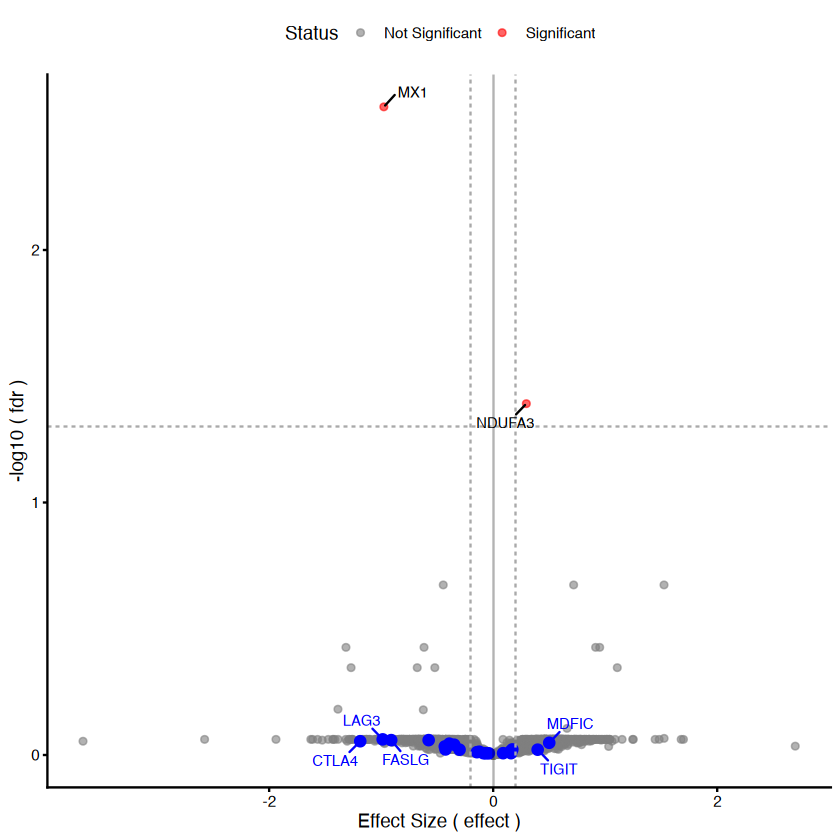

In [21]:
T_CELL_EXHAUSTION <- c(
  "BATF", "CASP3", "CCL3", "CD160", "CD244", "CD86",
  "CTLA4", "EOMES", "FASLG", "HAVCR2", "IER5", "IRF4",
  "KLRG1", "LAG3", "LILRB4", "MDFIC", "PBX3", "PDCD1",
  "PLSCR1", "PTGER2", "RGS16", "TIGIT", "TNFRSF9", "TNFSF9"
)

# Plot
plot_volcano(
  df = res_df, 
  x_col = "effect", 
  y_col = "fdr", 
  x_cut = 0.2,       # Threshold for effect size
  p_cut = fdr_cut,      # Threshold for p-value/fdr
  genes_of_interest = T_CELL_EXHAUSTION
)

## Run the standard smiDE

In [26]:
load_de_obj <- FALSE
de_obj_path <- file.path(full_out_dir, "de_obj.RDS")

In [27]:
## define the problem:
# which cells to analyze: (a logical vector over all cells)
inds <- (metadata[[celltype_col]] == celltype_oi)

# Calculate Scale Factors
totalcounts <- Matrix::rowSums(counts)
totalcounts_scalefactors <- mean(totalcounts) / totalcounts
names(totalcounts_scalefactors) <- rownames(counts)

# Create the formula string
if (use_random_intercept) {
    formula_str <- paste0("~RankNorm(otherct_expr) + offset(log(nCount_RNA)) + ", de_var, " + (1 | ", random_intercept_col,")")
} else {
    formula_str <- paste0("~RankNorm(otherct_expr) + offset(log(nCount_RNA)) + ", de_var) # <----- first two terms adjust for segmentation errors and per-cell signal strength, final term is the variable to be analyzed, must be a column in metadata
}

print(formula_str)

[1] "~RankNorm(otherct_expr) + offset(log(nCount_RNA)) + log.neighboring.tumor_bins_simple + (1 | study_id)"


In [28]:
if (load_de_obj) {
    de_obj <- readRDS(de_obj_path)
} else {
## run smiDE with a Negative Binomial model and no spatial correlation modeling:
de_obj <- 
   smi_de(assay_matrix = Matrix::t(counts),
          metadata = metadata[inds, ],
          formula = as.formula(formula_str),   
          pre_de_obj = pre_de_obj,  # depends on pre_de_obj calculated earlier
          cellid_colname = cellid_col,
          neighbor_expr_cell_type_metadata_colname = celltype_col,
          neighbor_expr_overlap_weight_colname = NULL,
          neighbor_expr_overlap_agg ="sum",
          neighbor_expr_totalcount_normalize = TRUE,
          neighbor_expr_totalcount_scalefactor = totalcounts_scalefactors,
          family="nbinom2",
          targets=genes_to_analyze     # calculated earlier
   )
saveRDS(de_obj, file = de_obj_path)
}

In [10]:
path_test <- "/Users/fs2829/Documents/CosMX/cosmx_analysis_github/cosmx_rna/data/de_obj_all_cores_bins_simple.rds"
de_obj <- readRDS(path_test)

### Results Standard smiDE

In [13]:
res <- smiDE::results(de_obj)  # use res$pairwise for most cases. res$one.vs.rest can also be useful. 
res_pw <- smiDE::results(de_obj, comparisons = "pairwise", variable = de_var)$pairwise
vlist <- smiDE::volcano(de_obj, comparison = "pairwise", variable=de_var, interactive = FALSE)

In [14]:
# Check comparison names
unique(res_pw$contrast)

[1] Close to tumor / Far from tumor Close to tumor / Middle        
[3] Far from tumor / Middle        
3 Levels: Close to tumor / Far from tumor ... Far from tumor / Middle

In [15]:
# Extract results for a specific comparison
comp_name <- "Close to tumor / Far from tumor"
fdr_cut <- 0.05
x_cut <- 0.5

# filter for contrast
res_df <- res_pw[res_pw$contrast == comp_name, ]

# Create a clean dataframe for plotting
res_df <- data.frame(
  gene = res_df$target,
  FC = res_df$fold_change,
  log2FC = log2(res_df$fold_change), # Calculate log2 Fold Change
  p_raw = res_df$p.value
)

# Calculate FDR (Multiple testing correction)
res_df$fdr <- p.adjust(res_df$p_raw, method = "BH")

# Set row names to gene names for the plot labels
rownames(res_df) <- res_df$gene

In [16]:
top_n <- 10
# Top N Up-regulated
top_up <- res_df[res_df$fdr < 0.05 & res_df$log2FC > 0, ]
top_up <- top_up[order(top_up$log2FC, decreasing = TRUE), ]
head(top_up, top_n)

# Top 10 Up-regulated (Close to tumor)
top_down <- res_df[res_df$fdr < 0.05 & res_df$log2FC < 0, ]
top_down <- top_down[order(top_down$log2FC), ]
head(top_down, top_n)

,gene,FC,log2FC,p_raw,fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CCL4,CCL4,1.466427,0.5523055,2.921456e-04,0.0362880302
STARD3,STARD3,1.440844,0.5269141,2.886010e-04,0.0362880302
RGS1,RGS1,1.416839,0.5026760,5.487412e-07,0.0002564708
CXCL13,CXCL13,1.406488,0.4920972,2.334249e-05,0.0059177203


,gene,FC,log2FC,p_raw,fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ZBTB16,ZBTB16,0.5821389,-0.7805648,9.401462e-06,2.752614e-03
TCF7,TCF7,0.6105434,-0.7118343,5.065870e-11,6.921667e-08
GAR1,GAR1,0.6597813,-0.5999402,1.009258e-06,3.447458e-04
SELL,SELL,0.6884422,-0.5385926,8.120263e-07,3.025905e-04
SYF2,SYF2,0.6909957,-0.5332514,3.395731e-04,4.093853e-02
TXNIP,TXNIP,0.6911913,-0.5328431,6.539081e-26,2.680369e-22
RASGRP2,RASGRP2,0.6959126,-0.5230219,7.244347e-06,2.284198e-03
CCR7,CCR7,0.6963488,-0.5221180,3.024091e-05,6.886528e-03
VSIR,VSIR,0.7020759,-0.5103011,1.705476e-04,2.496694e-02


Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


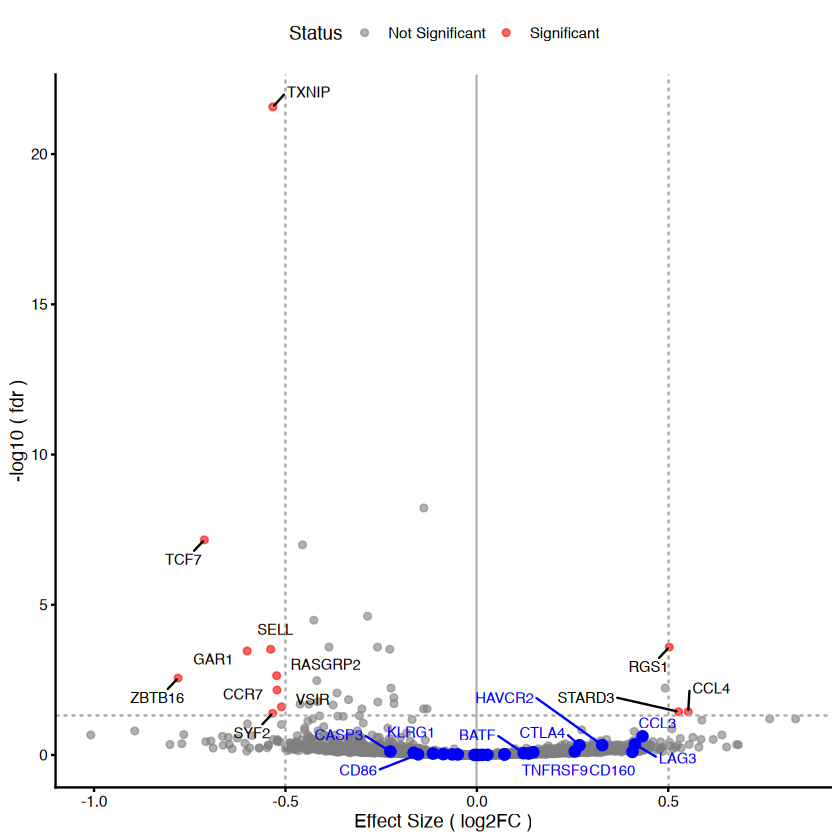

In [17]:
# Define genes you specifically want to investigate
T_CELL_EXHAUSTION <- c(
  "BATF", "CASP3", "CCL3", "CD160", "CD244", "CD86",
  "CTLA4", "EOMES", "FASLG", "HAVCR2", "IER5", "IRF4",
  "KLRG1", "LAG3", "LILRB4", "MDFIC", "PBX3", "PDCD1",
  "PLSCR1", "PTGER2", "RGS16", "TIGIT", "TNFRSF9", "TNFSF9"
)

volc_plot <- plot_volcano(
  df = res_df, 
  x_col = "log2FC", 
  y_col = "fdr",
  x_cut = x_cut,          
  p_cut = fdr_cut,        
  genes_of_interest = T_CELL_EXHAUSTION,
  y_trans = "-log10"
)

volc_plot

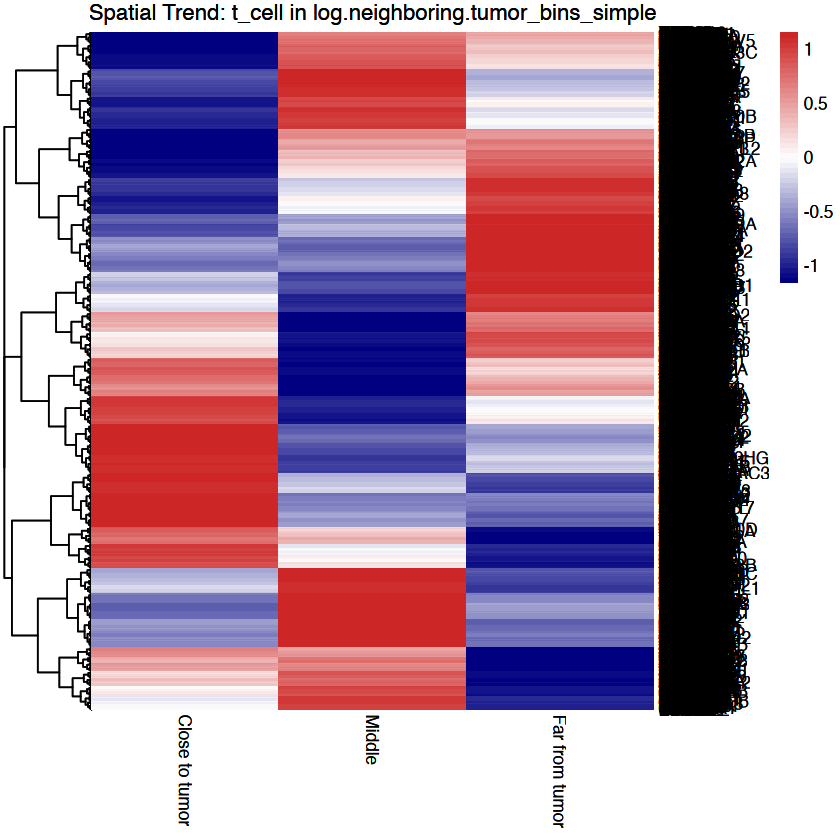

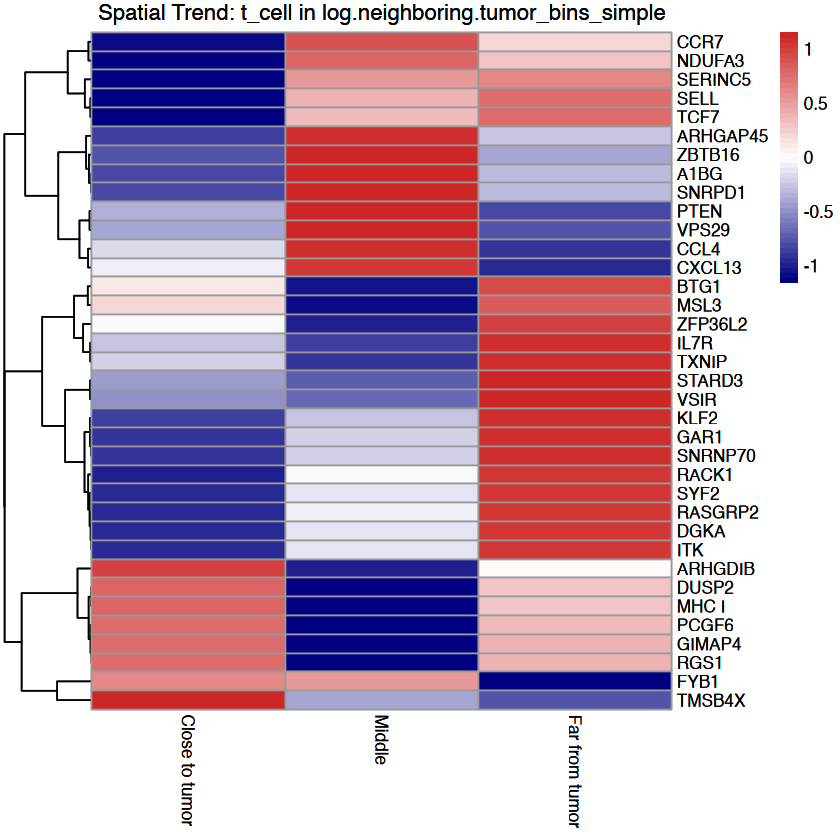

In [21]:
# Custom order of bin levels:
use_custom_order <- TRUE
custom_order <- c("Close to tumor", "Middle", "Far from tumor")

# Dynamic Subsetting
inds <- (metadata[[celltype_col]] == celltype_oi)
seu_subset <- subset(seu, cells = colnames(seu)[inds])

# Extract Data (Using Matrix-aware functions)
expr_subset <- Seurat::GetAssayData(seu_subset, slot = "data")
bins <- factor(seu_subset@meta.data[[de_var]]) # Force factor to ensure levels exist
if (use_custom_order) {
    bins <- factor(seu_subset@meta.data[[de_var]], levels = custom_order)
}
bin_levels <- levels(bins)

# Calculate Mean Expression per Bin
mean_mat <- sapply(bin_levels, function(b) {
  cells_in_bin <- bins == b
  if (sum(cells_in_bin) == 0) return(numeric(nrow(expr_subset))) # Handle empty bins
  Matrix::rowMeans(expr_subset[, cells_in_bin, drop = FALSE])
})

mean_mat <- as.matrix(mean_mat)
colnames(mean_mat) <- bin_levels

# CRITICAL: Remove genes with zero variance across bins. 
# pheatmap "scale='row'" divides by SD. If SD is 0, the row becomes NaNs.
keep_genes <- apply(mean_mat, 1, sd) > 0
mean_mat <- mean_mat[keep_genes, ]

# Visualize
full_genes_hm <- pheatmap::pheatmap(
  mean_mat,
  scale = "row",           # Z-score normalization (Trend focused)
  cluster_rows = TRUE,     # Groups genes with similar spatial patterns
  cluster_cols = FALSE,    # Keeps Close -> Middle -> Far order intact
  main = paste("Spatial Trend:", celltype_oi, "in", de_var),
  color = colorRampPalette(c("navy", "white", "firebrick3"))(50)
)
print(full_genes_hm)

# Only plot genes that passed FDR threshold in the DE test
sig_genes <- rownames(res_df)[res_df$fdr < fdr_cut]
plot_mat <- mean_mat[intersect(rownames(mean_mat), sig_genes), ]

sig_genes_hm <- pheatmap::pheatmap(
  plot_mat,
  scale = "row",           # Z-score normalization (Trend focused)
  cluster_rows = TRUE,     # Groups genes with similar spatial patterns
  cluster_cols = FALSE,    # Keeps Close -> Middle -> Far order intact
  main = paste("Spatial Trend:", celltype_oi, "in", de_var),
  color = colorRampPalette(c("navy", "white", "firebrick3"))(50)
)
print(sig_genes_hm)

$TCF7

$TXNIP


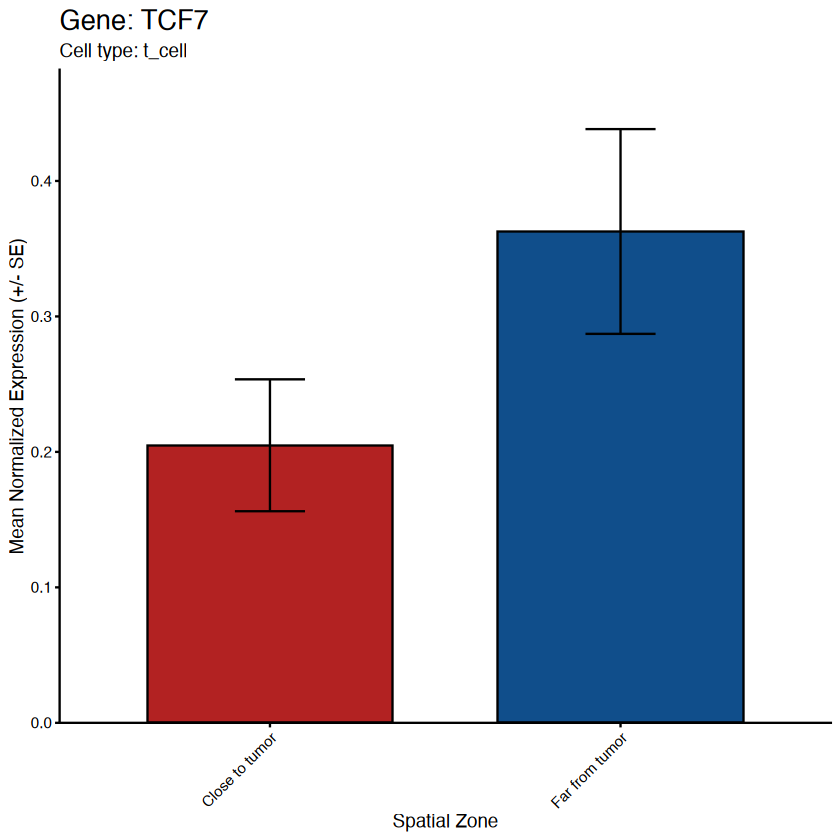

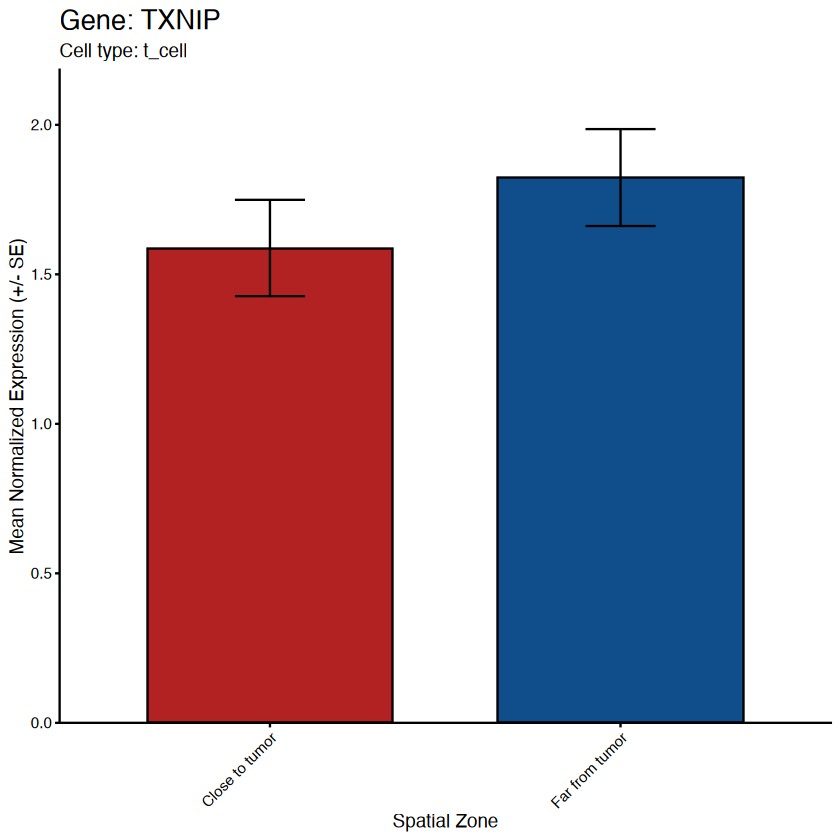

In [22]:
my_plots <- get_gene_bin_plot_list(
  seu_obj = seu_subset,
  genes = c("TCF7", "TXNIP"),
  bin_col = de_var,
  bins_to_include = c("Close to tumor", "Far from tumor"),
  bin_order = c("Close to tumor", "Far from tumor"),
  bin_colors = c("Close to tumor" = "firebrick", "Far from tumor" = "dodgerblue4")
)

my_plots

Warning message:
“Scaling data with a low number of groups may produce misleading results”


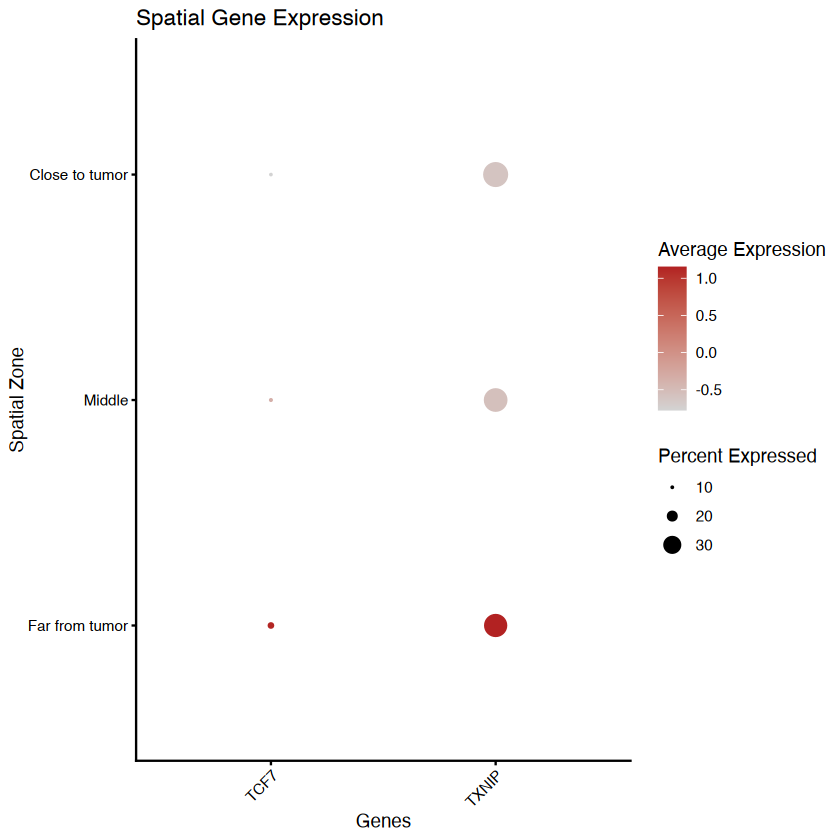

In [34]:
my_bin_order <- c("Far from tumor", "Middle", "Close to tumor")

dotplot <- generate_spatial_dotplot(seu_subset, 
                         genes = c("TCF7", "TXNIP"), 
                         bin_col = de_var,
                         bin_order = my_bin_order,
                         scale = TRUE)
dotplot

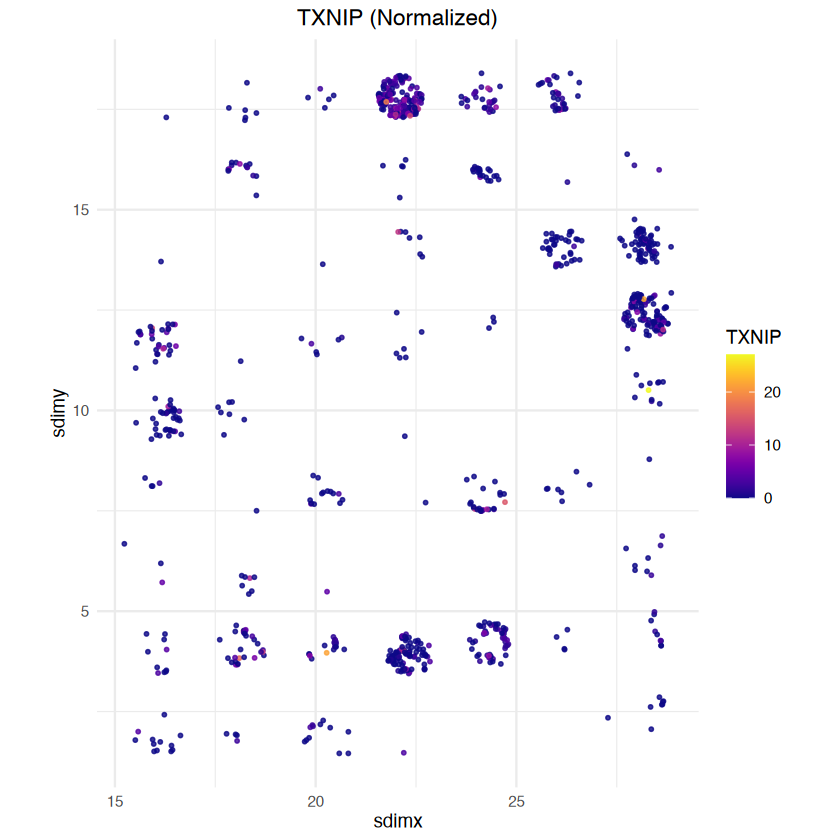

In [32]:
# Configuration
target_gene <- "TXNIP"
data_mode   <- "normalized" # Options: "raw", "normalized", "log_normalized"

# Extract Data based on data_mode
if (data_mode == "raw") {
  # Pull from the 'counts' slot
  expr_vals <- FetchData(seu_subset, vars = target_gene, slot = "counts")[[1]]
  pal_option <- "viridis"
  plot_title <- paste(target_gene, "(Raw Counts)")
  
} else if (data_mode == "normalized") {
  # Pull from 'data' slot
  expr_vals <- FetchData(seu_subset, vars = target_gene, slot = "data")[[1]]
  pal_option <- "plasma"
  plot_title <- paste(target_gene, "(Normalized)")
  
} else if (data_mode == "log_normalized") {
  # Extract normalized data and apply log1p
  raw_norm <- FetchData(seu_subset, vars = target_gene, slot = "data")[[1]]
  expr_vals <- log1p(raw_norm)
  pal_option <- "magma"
  plot_title <- paste(target_gene, "(Log-Normalized)")
}

# Prepare Metadata
# create a copy to avoid polluting the original Seurat metadata
plot_md <- data.table::as.data.table(seu_subset@meta.data)
plot_md[[target_gene]] <- expr_vals

# 4. Call xyplot
# Ensure x_column and y_column match your Seurat metadata names
xy_plot <- xyplot(
  cluster_column = target_gene,
  metadata = plot_md,
  x_column = "sdimx", 
  y_column = "sdimy",
  ptsize = 0.6,
  alphasize = 0.8,
  continuous_palette = function(n) viridis::viridis(n, option = pal_option),
  theme = theme_minimal() + theme(plot.title = element_text(hjust = 0.5))
) + labs(title = plot_title)

xy_plot

In [37]:
pdf_filename <- file.path(full_out_dir, paste0("smiDE_standard_visualizations.pdf"))

pdf(pdf_filename, width = 7, height = 6)
print(volc_plot)
dev.flush()  # force page break after plot
plot.new()

print(full_genes_hm)
dev.flush()
plot.new()

print(sig_genes_hm)
dev.flush()
plot.new()

print(my_plots)
print(dotplot)
print(xy_plot)
print(vlist)
dev.off()
cat(sprintf("Saved compiled plots to: %s\n", pdf_filename))


Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] 0

[1] 0

[1] 0

$TCF7

$TXNIP

$`Close to tumor / Far from tumor`


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'Far from tumor ← log₂(FC) → Close to tumor' in 'mbcsToSbcs': <- substituted for ← (U+2190)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Far from tumor ← log₂(FC) → Close to tumor' in 'mbcsToSbcs': for ₂ (U+2082)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'Far from tumor ← log₂(FC) → Close to tumor' in 'mbcsToSbcs': -> substituted for → (U+2192)”



$`Close to tumor / Middle`


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'Middle ← log₂(FC) → Close to tumor' in 'mbcsToSbcs': <- substituted for ← (U+2190)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Middle ← log₂(FC) → Close to tumor' in 'mbcsToSbcs': for ₂ (U+2082)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'Middle ← log₂(FC) → Close to tumor' in 'mbcsToSbcs': -> substituted for → (U+2192)”



$`Far from tumor / Middle`


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'Middle ← log₂(FC) → Far from tumor' in 'mbcsToSbcs': <- substituted for ← (U+2190)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Middle ← log₂(FC) → Far from tumor' in 'mbcsToSbcs': for ₂ (U+2082)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'Middle ← log₂(FC) → Far from tumor' in 'mbcsToSbcs': -> substituted for → (U+2192)”


agg_record_1866839656 
                    2

Saved compiled plots to: ./output/TMA12/DGE/smiDE_standard_visualizations.pdf


## Run the spatial smiDE

In [22]:
load_spatial_de_obj <- FALSE
spatial_de_obj_path <- file.path(full_out_dir, "spatial_de_obj.RDS")

In [23]:
# Run smiDE on the top genes with the optimal / spatial-aware call to smiDE:
## define the problem:

# which cells to analyze: (a logical vector over all cells)
inds <- (metadata[[celltype_col]] == celltype_oi)

metadata[[sdimx_col]] <- xy[, 1]
metadata[[sdimy_col]] <- xy[, 2]
totalcounts <- Matrix::rowSums(counts)
names(totalcounts) <- rownames(counts)
totalcounts_scalefactors <- mean(totalcounts) / totalcounts
names(totalcounts_scalefactors) <- rownames(counts)

# Create the formula string
if (use_random_intercept) {
    formula_str <- paste0("~RankNorm(otherct_expr) + offset(log(nCount_RNA)) + ", de_var, " + (1 | ", random_intercept_col,")")
} else {
    formula_str <- paste0("~RankNorm(otherct_expr) + offset(log(nCount_RNA)) + ", de_var) # <----- first two terms adjust for segmentation errors and per-cell signal strength, final term is the variable to be analyzed, must be a column in metadata
}

print(formula_str)

[1] "~RankNorm(otherct_expr) + offset(log(nCount_RNA)) + log.neighboring.tumor_bins_simple + (1 | study_id)"


In [24]:
# Extract Top Genes
top_n <- 10
comp_name <- "log.neighboring.tumor_bins_simpleFar from tumor"

# Prepare the dataframe
fast_df <- data.frame(
  gene = rownames(fastres$effect),
  effect = fastres$effect[, comp_name],
  p_raw = fastres$p[, comp_name]
)

# Identify the p-value threshold for the top 1%
p_threshold <- quantile(fast_df$p_raw, 0.01, na.rm = TRUE)

# If p <= threshold, score = absolute effect. If not, score = 0.
ranking_score <- ifelse(fast_df$p_raw <= p_threshold, abs(fast_df$effect), 0)

# Get the indices of the top N scores
top_idx <- order(ranking_score, decreasing = TRUE)[1:top_n]

# Extract the gene names
topgenes <- fast_df$gene[top_idx]

topgenes

[1] "XCL1/2"  "RASGRP2" "PINK1"   "CD200"   "NHLRC3"  "PPA1"    "AAK1"   
 [8] "SCARF1"  "DDB2"    "VRK2"

In [28]:
## run smiDE with a Negative Binomial model and with spatial correlation modeling:
if (load_spatial_de_obj) {
    spatial_de_obj <- readRDS(spatial_de_obj_path)
} else {
spatial_de_obj <- 
   smi_de(assay_matrix = Matrix::t(counts),
          metadata = metadata[inds, ],
          formula = as.formula(formula_str),
          pre_de_obj = pre_de_obj,   
          cellid_colname = cellid_col,
          neighbor_expr_cell_type_metadata_colname = celltype_col,
          neighbor_expr_overlap_weight_colname = NULL,
          neighbor_expr_overlap_agg ="sum",
          neighbor_expr_totalcount_normalize = TRUE,
          neighbor_expr_totalcount_scalefactor = totalcounts_scalefactors,
          family="nbinom2",
          targets=topgenes,     # only analyze the genes of greatest interest
          spatial_model = list(name="GP_Matern",
                            #    k_prop_n = 0.25,
                               k = 10,
                              #  split_neighbors_by_colname=split_neighbors_by_colname,
                               x_coord_col = sdimx_col,  
                               y_coord_col = sdimy_col,
                               spatial_random_effect =  ~Matern(1 | sdimx_cluster + sdimy_cluster)
                               )          
   )
   saveRDS(spatial_de_obj, file = spatial_de_obj_path)
}

Creating k-means clusters for spatial random effects.

Warning message in xy_kmeans_clusters(metainfo, x_coord_col = spatial_args[["x_coord_col"]], :
“Warning: using provided number of clusters 'k'=10 and ignoring k_prop_n=0.2”
Warning message:
“the ‘findbars’ function has moved to the reformulas package. Please update your imports, or ask an upstream package maintainter to do so.
This warning is displayed once per session.”


ERROR: Error in ref_grid(result, ...): We are unable to reconstruct the data.
The variables needed are:
	otherct_expr log.neighboring.tumor_bins_simple nCount_RNA offsetuse
Are any of these actually constants? (specify via 'params = ')
The dataset name is:
	(raw data structure)
Does the data still exist? Or you can specify a dataset via 'data = '



## Setting Parameters

In [33]:
method <- "semisup"
cohorting <- TRUE
subset <- TRUE
run_umap <- TRUE

# other definitions
region_col <- "region"
ASSAY_NAME <- "RNA"
condition_col <- "condition"

In [ ]:
# Set RNA as Default Assay
DefaultAssay(seu) <- ASSAY_NAME

## Applying subsetting

In [10]:
# Testing Code
set.seed(123) # for reproducibility
if (ncol(seu) > 20000) {
    sampled_cells <- sample(colnames(seu), 20000)
    seu <- seu[, sampled_cells]
}


In [11]:
if (subset) {

    # Filter for Tumor Cores only
    seu <- subset(seu, subset = condition %in% c("T"))

}

# Drop unused levels
seu@meta.data[[region_col]] <- droplevels(seu@meta.data[[region_col]])

Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


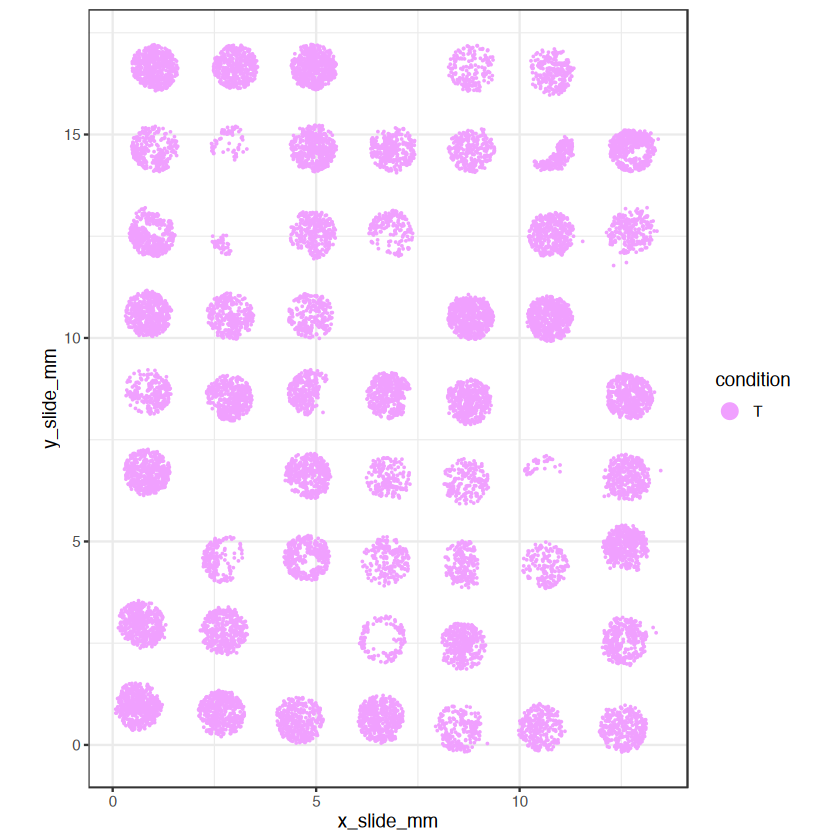

In [16]:
# Visualize the data
xyplot(condition_col, metadata = seu@meta.data, ptsize = 0.01) + coord_fixed()

## Define Inputs for Cell Typing

In [12]:
# Counts Data
counts <- Matrix::t(seu[[ASSAY_NAME]]@counts)

In [13]:
# mean negative control value
negmean <- Matrix::colMeans(seu[["negprobes"]])

## Unsupervised

## Semisupervised

### Parameters

In [18]:
# Parameters
n_clusts <- 10

### Cohorting

In [19]:
if (cohorting) {
    # Extract staining columns
    cohort_features <- as.matrix(seu@meta.data[, c("Mean.PanCK", "Mean.CD45")])
    # Compute cohort assignments
    coh <- fastCohorting(cohort_features, gaussian_transform = TRUE, n_cohorts = 10)
}

### Load Reference Profiles

In [21]:
reference_path <- "./data/InsituType_reference/BreastCancer_6k.profiles.csv"

In [22]:
refprofiles <- read.csv(file.path(reference_path), row.names = 1, header = TRUE)
refprofiles <- refprofiles[is.element(rownames(refprofiles), colnames(counts)), ]

In [23]:
refprofiles[1:5, 1:10]

,B.cell,Conventional.dendritic.cell,Endothelial,Fibroblast,Macrophage,Malignancy,Monocyte,Neutrophil,NK.cell,Pericyte
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M,0.19577904,0.13974522,3.3880371,0.3183390,0.6494423,0.07709235,0.17814614,0.14946842,0.21039954,1.41193139
AAAS,0.07594901,0.09006369,0.1364224,0.1057079,0.1154256,0.24387233,0.09785747,0.08630394,0.08000865,0.08562897
AAK1,0.05923513,0.06925690,0.1094636,0.0959437,0.1173349,0.16354170,0.07981507,0.06504065,0.11087552,0.08003812
AAMP,0.13657224,0.11341826,0.1934288,0.1303262,0.1536127,0.28112141,0.13394226,0.10881801,0.12284725,0.11536213
AARS1,0.11447592,0.09643312,0.2066274,0.1405059,0.1403477,0.55345833,0.08252143,0.13008130,0.09861532,0.13162643


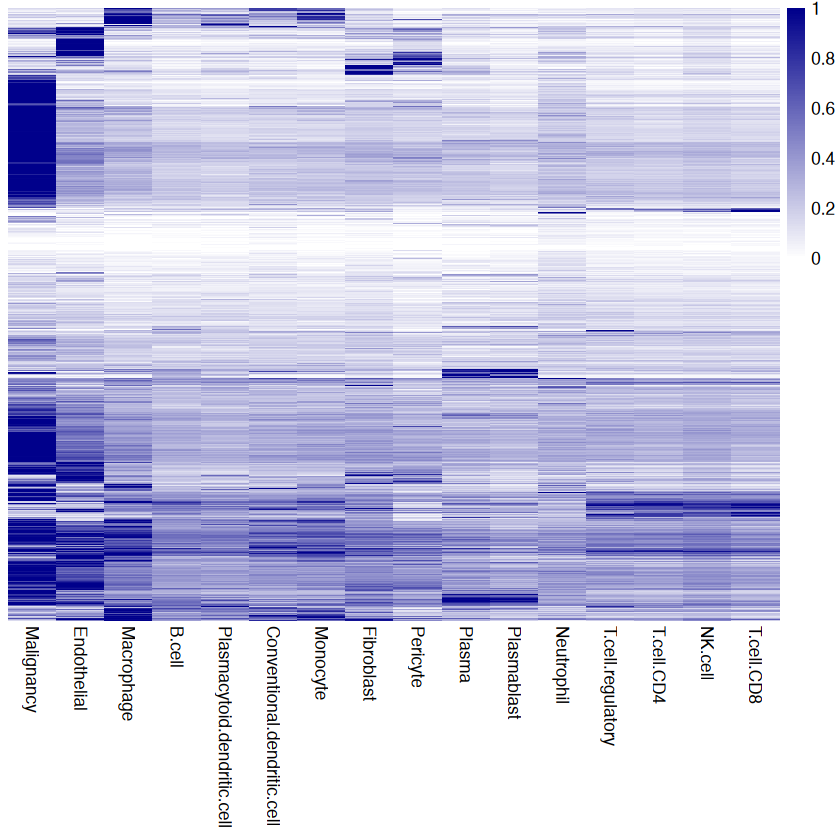

In [24]:
pheatmap::pheatmap(sweep(refprofiles, 1, pmax(apply(refprofiles, 1, max), 0.2), "/"), 
                   col = colorRampPalette(c("white", "darkblue"))(100), 
        treeheight_row = 0,    # hides row dendrogram
        treeheight_col = 0,    # hides column dendrogram
        show_rownames = FALSE  # hides y-axis labels
)

In [25]:
if (method == "semisup") {

  semisup <- insitutype(
    x = counts,
    neg = negmean,
    cohort = if (cohorting) coh else NULL,
    bg = NULL,
    # condensed to save time. n_clusts = 5:15 would be more optimal
    n_clusts = n_clusts,
    reference_profiles = refprofiles,
    update_reference_profiles = FALSE,
    # choosing inadvisably low numbers to speed the vignette; using the defaults
    # in recommended.
    # n_phase1 = 200,
    # n_phase2 = 500,
    # n_phase3 = 2000,
    # n_starts = 1,
    # max_iters = 5
  ) 

}

The following genes in the count data are missing from fixed_profiles and will be omitted from downstream: A1BG,AATK,ACAA2,ACAT2,ACKR1,ADGRE1,ADH1B,ADIRF,AFF2,AGA,AGPAT5,AGRP,AK1,ALDH1L1,ANAPC16,ANGPTL4,ANXA2,AP1S2,AP4E1,APOA1,APOD,AREG,ARNT2,ARX,ASB6,ATF3,ATG4D,ATP1A3,AVPR1B,AXIN2,BIRC3,BOLA2,BST1,C11orf96,C4BPA,C5,C7,C8G,CACNA1A,CADM4,CALML4,CAMTA1,CASP7,CAV2,CCDC80,CCL2,CCL20,CCL21,CCL3,CCNB1,CCND2,CCR10,CD160,CD1C,CD1E,CD22,CD320,CD68,CD83,CD99,CDH11,CDK11A,CDKN2B,CDKN2C,CENPW,CEP164,CFD,CFP,CHIT1,CHL1,CHORDC1,CHPT1,CIB2,CIR1,CLN5,CLU,CMC1,CNIH4,CNTN2,COL18A1,COL1A1,COL3A1,COL4A2,COL4A3,COL5A2,COL8A1,CPAMD8,CPE,CPT2,CRYAB,CSNK2A1,CTNND1,CTSF,CX3CR1,CXCL1,CXCL2,CXCL3,CXCL5,CXCL8,CXCR2,CXCR6,CYCS,CYP1B1,DAAM1,DCN,DCTN5,DDIT3,DERL2,DHX29,DHX38,DISC1,DNAJB1,DTX4,DUSP2,DVL2,EDEM3,EGR1,EIF1AY,ELF4,EMP3,ENDOG,ENY2,EPN1,EREG,ESR2,ESRRA,EZR,F12,FA2H,FAAP20,FAP,FCER1A,FCGR2B,FGF13,FGFBP2,FLRT2,FLT3,FOS,FOSB,FUCA1,FUNDC1,G0S2,GAN,GAR1,GHR,GNG2,GNG7,GPM6A,GPM6B,GPX2,GRIP1,GTF2H5,HADHB,HBB,HBEG

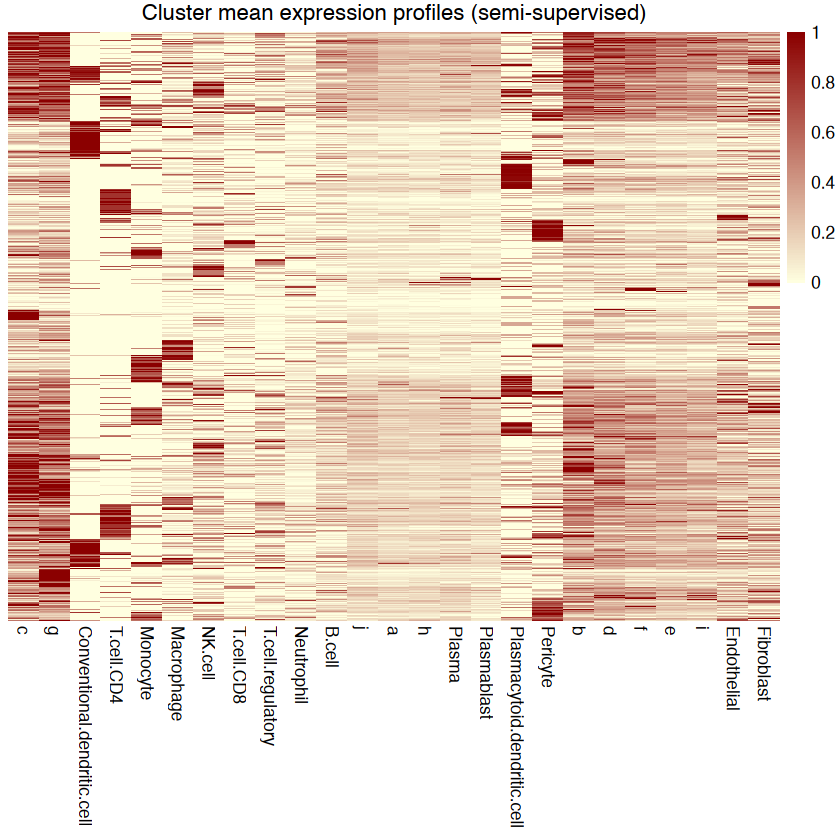

In [ ]:
# heatmap(sweep(semisup$profiles, 1, pmax(apply(semisup$profiles, 1, max), .2), "/"), scale = "none",
#         main = "Cluster mean expression profiles (semi-supervised)")

pheatmap::pheatmap(sweep(semisup$profiles, 1, pmax(apply(semisup$profiles, 1, max), .2), "/"), scale = "none", col = colorRampPalette(c("lightyellow", "darkred"))(100),
        main = "Cluster mean expression profiles (semi-supervised)", treeheight_row = 0, treeheight_col = 0, show_rownames = FALSE)

In [42]:
clusters <- semisup$clust
all(names(clusters) %in% colnames(seu))

# Create a vector with NA for all cells, then fill where available
cluster_metadata <- rep(NA, ncol(seu))
names(cluster_metadata) <- colnames(seu)

# Fill in clusters for matching cells
cluster_metadata[names(clusters)] <- clusters

# Add to Seurat object metadata
if (cohorting) {
    seu$IST_clusters_cohort_initial <- as.factor(cluster_metadata)
    table(seu$IST_clusters_cohort_initial)
    seu$seurat_clusters <- as.factor(cluster_metadata)
    orig_levels <- levels(seu$IST_clusters_cohort_initial)
} else {
    seu$IST_clusters_cohort_initial <- as.factor(cluster_metadata)
    table(seu$IST_clusters_initial)
    seu$seurat_clusters <- as.factor(cluster_metadata)
    orig_levels <- levels(seu$IST_clusters_initial)
}

# Identify single letter levels (a single character, not counting ".")
single_letter_levels <- orig_levels[nchar(gsub("\\.", "", orig_levels)) == 1]
not_single_letter_levels <- setdiff(orig_levels, single_letter_levels)

# New order: non-single-letter levels, then the single letters
new_levels <- c(not_single_letter_levels, single_letter_levels)
if (cohorting) {
    seu$IST_clusters_cohort_initial <- factor(seu$IST_clusters_cohort_initial, levels = new_levels)
} else {
    seu$IST_clusters_initial <- factor(seu$IST_clusters_initial, levels = new_levels)
}

[1] TRUE

### Saving data

In [28]:
suffix <- "_initial"
seu_filepath <- file.path(full_out_dir, paste0("merged_object_", study_name, "_IST_", method, suffix,".RDS"))
saveRDS(seu, seu_filepath)

In [29]:
semisup_filepath <- file.path(full_out_dir, paste0("InsituType_Result_", study_name, "_", method, suffix,".RDS"))
saveRDS(semisup, semisup_filepath)

### (Optional) Loading results data

In [30]:
# Dynamically load the data saved in the previous cells

suffix <- "_initial"
seu_filepath <- file.path(full_out_dir, paste0("merged_object_", study_name, "_IST_", method, suffix,".RDS"))
semisup_filepath <- file.path(full_out_dir, paste0("InsituType_Result_", study_name, "_", method, suffix,".RDS"))

seu <- readRDS(seu_filepath)
semisup <- readRDS(semisup_filepath)

### Visualizing Initial Results

In [31]:
# Define colors
cluster_cls <- InSituType::colorCellTypes(freqs = table(semisup$clust), palette = "brewers")

cluster_cls["a"] <- "darkred"
cluster_cls["b"] <- "lightpink"
cluster_cls["c"] <- "firebrick"
cluster_cls["d"] <- "salmon"
cluster_cls["e"] <- "indianred1"
cluster_cls["f"] <- "red"
cluster_cls["g"] <- "darkred"
cluster_cls["h"] <- "tomato"
cluster_cls["i"] <- "mistyrose"
cluster_cls["j"] <- "lightcoral"

# T cell subtypes (shades of blue)
cluster_cls["T.cell.CD8"]       <- "navy"
cluster_cls["T.cell.CD4"]       <- "dodgerblue3"
cluster_cls["T.cell.regulatory"]<- "skyblue"

# Plasma / B cell subtypes (shades of orange)
cluster_cls["Plasma"]           <- "darkorange"
cluster_cls["Plasmablast"]      <- "orange"

# Myeloid subtypes (shades of tan/brown)
cluster_cls["Macrophage"]       <- "tan3"
cluster_cls["Monocyte"]         <- "tan2"
cluster_cls["Neutrophil"]       <- "wheat4"

# Tumor / malignancy (shades of red)
cluster_cls["tumor"]            <- "firebrick2"
cluster_cls["Malignancy"]       <- "red3"

# NK cell
cluster_cls["NK.cell"]          <- "deepskyblue1"

# Endothelial
cluster_cls["Endothelial"]      <- "mediumorchid1"

# B cell
cluster_cls["B.cell"]           <- "seagreen3"

# Fibroblast
cluster_cls["Fibroblast"]       <- "gray30"

# Dendritic cells (shades of yellow)
cluster_cls["Conventional.dendritic.cell"] <- "goldenrod2"
cluster_cls["Plasmacytoid.dendritic.cell"] <- "gold"

# Pericyte
cluster_cls["Pericyte"]         <- "deeppink1"

#### (Optional) Running UMAP

In [32]:
Reductions(seu)

NULL

In [34]:
if (run_umap) {
  # Run UMAP
  nfeatures = 3000
  run_prefix <- "scpearson"
  run_suffix <- "nobatch"
  slot_names = list(
      pca = paste0(run_prefix, "_pca_", run_suffix),
      umap = paste0(run_prefix, "_umap_", run_suffix),
      graph = paste0(run_prefix, "_graph_", run_suffix),
      clusters = paste0(run_prefix, "_clusters_", run_suffix)
  )

  results <- suppressMessages(suppressWarnings(
      apply_scPearsonPCA(seu, nfeatures = nfeatures, slot_names = slot_names)
  ))

  seu <- results$seu
  reduction <- slot_names$umap
}

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17765
Number of edges: 426372

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7916
Number of communities: 18
Elapsed time: 1 seconds


#### Generate PDF Report

In [43]:
if (cohorting) {
    cluster_col <- "IST_clusters_cohort_initial"
} else {
    cluster_col <- "IST_clusters_initial"
}

CT_QC_plot(seu = seu, cluster_col = cluster_col, cluster_pal = cluster_cls, annotation_col = NULL, annotation_pal = NULL, IST_obj = semisup, out_dir = full_out_dir, reduction = reduction)

[[1]]

[[2]]

[[3]]

[[4]]



Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Saving flightpath_plot to: ./NBClust-Plots/2026-01-07_14-48-21-EST-flightpath_plot.png



agg_record_1926825453 
                    2

### Refining Clusters / Initial Results

This should be performed iteratively. If the refinement is performed on already previously refined clusters, set already_refined to TRUE.

In [57]:
already_refined <- TRUE

#### (Optional) Load an already refined result

In [58]:
if (already_refined) {
    suffix <- "_refined"
    semisup_refined_filepath <- file.path(full_out_dir, paste0("InsituType_Result_", study_name, "_", method, suffix,".RDS"))
    semisup <- readRDS(semisup_refined_filepath)
}

In [59]:
if (already_refined) {
    unique(seu$IST_clusters_cohort_refined)
} else {
    unique(seu$IST_clusters_cohort_initial)
}

[1] e                           j                          
 [3] a                           Plasmablast                
 [5] Plasma                      d                          
 [7] i                           Fibroblast                 
 [9] Pericyte                    b                          
[11] Macrophage                  Endothelial                
[13] NK.cell                     c                          
[15] B.cell                      T.cell.regulatory          
[17] T.cell.CD8                  f                          
[19] T.cell.CD4                  Neutrophil                 
[21] Plasmacytoid.dendritic.cell g                          
[23] Conventional.dendritic.cell Monocyte                   
24 Levels: B.cell Conventional.dendritic.cell Endothelial ... j

In [60]:
semisup_refined <- refineClusters(
      logliks = semisup$logliks, 
      counts = counts,
      neg = negmean, 
    #   merges = c("T.cell.CD4" = "T-cell",
    #              "T.cell.CD8" = "T-cell"),
    #   subcluster = list("d" = 2),      
      to_delete = c("g"))  # delete this cluster and send its cells to their next-best fit    

In [ ]:
clusters <- semisup_refined$clust
all(names(clusters) %in% colnames(seu))

# Create a vector with NA for all cells, then fill where available
cluster_metadata <- rep(NA, ncol(seu))
names(cluster_metadata) <- colnames(seu)

# Fill in clusters for matching cells
cluster_metadata[names(clusters)] <- clusters

# Add to Seurat object metadata
if (cohorting) {
    seu$IST_clusters_cohort_refined <- as.factor(cluster_metadata)
    table(seu$IST_clusters_cohort_refined)
    seu$seurat_clusters <- as.factor(cluster_metadata)
    orig_levels <- levels(seu$IST_clusters_cohort_refined)
} else {
    seu$IST_clusters_refined <- as.factor(cluster_metadata)
    table(seu$IST_clusters_refined)
    seu$seurat_clusters <- as.factor(cluster_metadata)
    orig_levels <- levels(seu$IST_clusters_refined)
}

# Identify single letter levels (a single character, not counting ".")
single_letter_levels <- orig_levels[nchar(gsub("\\.", "", orig_levels)) == 1]
not_single_letter_levels <- setdiff(orig_levels, single_letter_levels)

# New order: non-single-letter levels, then the single letters
new_levels <- c(not_single_letter_levels, single_letter_levels)
if (cohorting) {
    seu$IST_clusters_cohort_refined <- factor(seu$IST_clusters_cohort_refined, levels = new_levels)
} else {
    seu$IST_clusters_refined <- factor(seu$IST_clusters_refined, levels = new_levels)
}

In [61]:
suffix <- "_refined"

semisup_refined_filepath <- file.path(full_out_dir, paste0("InsituType_Result_", study_name, "_", method, suffix,".RDS"))
saveRDS(semisup_refined, semisup_refined_filepath)

seu_filepath <- file.path(full_out_dir, paste0("merged_object_", study_name, "_IST_", method, suffix,".RDS"))
saveRDS(seu, seu_filepath)

In [62]:
if (cohorting) {
    cluster_col <- "IST_clusters_cohort_refined"
} else {
    cluster_col <- "IST_clusters_refined"
}

CT_QC_plot(seu = seu, cluster_col = cluster_col, cluster_pal = cluster_cls, annotation_col = NULL, annotation_pal = NULL, IST_obj = semisup_refined, out_dir = full_out_dir, reduction = reduction)

[[1]]

[[2]]

[[3]]

[[4]]



Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Saving flightpath_plot to: ./NBClust-Plots/2026-01-07_15-37-35-EST-flightpath_plot.png



agg_record_1140107404 
                    2